<a href="https://colab.research.google.com/github/RomanGustavo/Mestrado---ML/blob/main/TrabalhoFinalEarthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from sklearn.model_selection import train_test_split

Carregar Dados

In [2]:
file = open('earthquake_data_tsunami.csv', 'r')
dados = np.loadtxt(file, delimiter=",", skiprows=1)

print("Shape dados (linhas, colunas):", dados.shape)

# X: todas as colunas menos a última
X = dados[:, :-1]
# y: última coluna (tsunami)
y = dados[:, -1]
y = y.reshape((-1, 1))

print("Shape X:", X.shape)
print("Shape y:", y.shape)

print("Primeiro X:", X[0])
print("Primeiro y:", y[0,0])

Shape dados (linhas, colunas): (782, 13)
Shape X: (782, 12)
Shape y: (782, 1)
Primeiro X: [ 7.00000e+00  8.00000e+00  7.00000e+00  7.68000e+02  1.17000e+02
  5.09000e-01  1.70000e+01  1.40000e+01 -9.79630e+00  1.59596e+02
  2.02200e+03  1.10000e+01]
Primeiro y: 1.0


Normalização

In [5]:
camada_norm = tf.keras.layers.Normalization(axis=-1)
camada_norm.adapt(X)          # calcula média/variância
X_norm = camada_norm(X).numpy()       # aplica normalização

Separar treino/val

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_norm, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)


X_train: (547, 12) X_val: (235, 12)


Definir modelo

In [7]:
n_features = X_train.shape[1]

modelo = Sequential(
    [
        tf.keras.Input(shape=(n_features,)),
        Dense(10, activation="relu"),
        Dense(5, activation="relu"),
        Dense(1, activation="sigmoid")
    ],
    name="modelo_terremoto_tsunami"
)

modelo.summary()

Model: "modelo_terremoto_tsunami"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191 (764.00 B)

 Trainable params: 191 (764.00 B)

 Non-trainable params: 0 (0.00 B)

Compilar e treinar

In [8]:
modelo.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy"]
)

hist = modelo.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3743 - loss: 0.8630 - val_accuracy: 0.4170 - val_loss: 0.8355
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4405 - loss: 0.7747 - val_accuracy: 0.4553 - val_loss: 0.7753
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4876 - loss: 0.7212 - val_accuracy: 0.4809 - val_loss: 0.7342
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5351 - loss: 0.6890 - val_accuracy: 0.5277 - val_loss: 0.7031
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6247 - loss: 0.6479 - val_accuracy: 0.6085 - val_loss: 0.6811
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6485 - loss: 0.6528 - val_accuracy: 0.6298 - val_loss: 0.6603
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7109 - loss: 0.6317 - val_accuracy: 0.6511 - val_loss: 0.6416
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7461 - loss: 0.5941 - val_accuracy: 0.6766 - val_l

Avaliação

In [9]:
Prob_train = modelo(X_train)
Yhat_train = (Prob_train.numpy() >= 0.5).astype(int)
taxa_acerto_train = np.mean((Yhat_train == y_train) * 100)
print(f"Taxa de acerto (treino): {taxa_acerto_train:.2f}%")

Prob_val = modelo(X_val)
Yhat_val = (Prob_val.numpy() >= 0.5).astype(int)
taxa_acerto_val = np.mean((Yhat_val == y_val) * 100)
print(f"Taxa de acerto (validação): {taxa_acerto_val:.2f}%")

Taxa de acerto (treino): 85.56%
Taxa de acerto (validação): 84.68%


Grafico de Barras

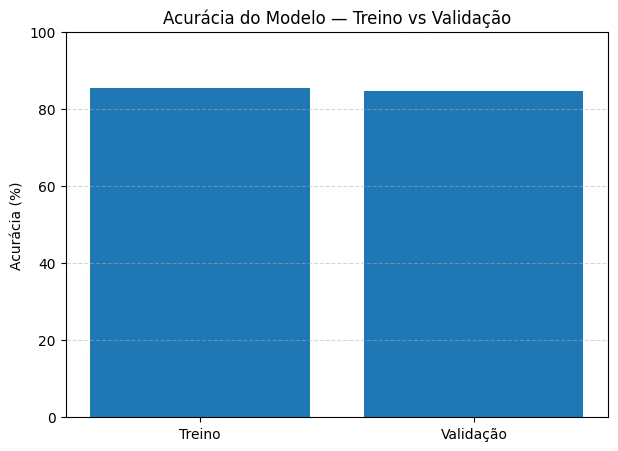

In [10]:
acc_train = taxa_acerto_train
acc_val = taxa_acerto_val

plt.figure(figsize=(7,5))
plt.bar(["Treino", "Validação"], [acc_train, acc_val])
plt.ylim(0, 100)
plt.ylabel("Acurácia (%)")
plt.title("Acurácia do Modelo — Treino vs Validação")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

Grafico Evolução

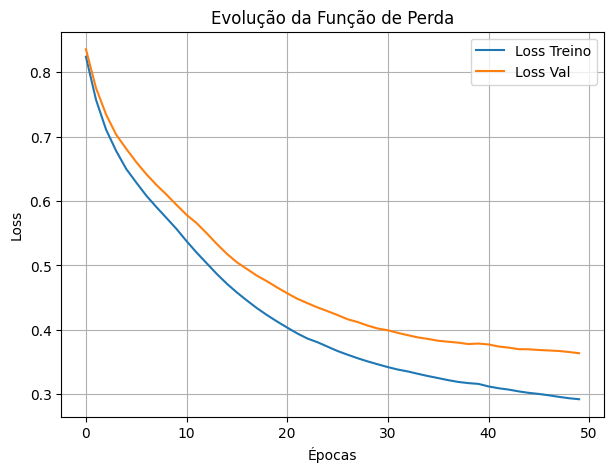

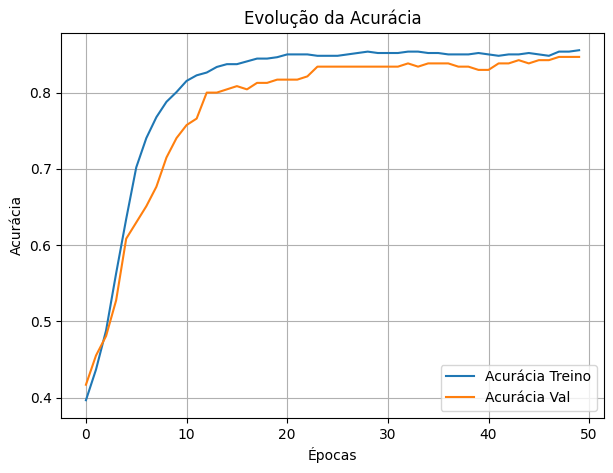

In [11]:
# LOSS
plt.figure(figsize=(7,5))
plt.plot(hist.history["loss"], label="Loss Treino")
plt.plot(hist.history["val_loss"], label="Loss Val")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolução da Função de Perda")
plt.grid(True)
plt.legend()
plt.show()

# ACCURACY
plt.figure(figsize=(7,5))
plt.plot(hist.history["accuracy"], label="Acurácia Treino")
plt.plot(hist.history["val_accuracy"], label="Acurácia Val")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Evolução da Acurácia")
plt.grid(True)
plt.legend()
plt.show()